In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fmr2e
import cv2
from tqdm import tqdm

Loading DLC 2.3.7...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [2]:
basepath = r'K:\FreelyMovingEyecams\241204_DMM_DMM031_freelymoving'
rec_name = '241204_DMM_DMM031_freelymoving_01'

In [ ]:
# reye = fmr2e.Eyecam(basepath, rec_name)
# reye.find_files()
# ellipse_fit_results = reye.track_pupil()
# reye.save_tracking(ellipse_fit_results)

100%|██████████| 83522/83522 [00:11<00:00, 7538.49it/s]


LinAlg error count = 130
boolean index did not match indexed array along dimension 1; dimension is 83522 but corresponding boolean dimension is 836
Error in scale, center, and calibration figures. Skipping these for now


In [ ]:
top = fmr2e.Topcam(basepath, rec_name)
top.find_files()
body_tracking_results = top.track_body()
top.save_tracking(body_tracking_results)

In [7]:
body_tracking_results.keys()

dict_keys(['speed', 'head_yaw', 'body_yaw', 'body_head_diff', 'movement_yaw', 'movement_minus_body', 'forward_run', 'backward_run', 'fine_motion', 'stationary', 'topT', 'x', 'y', 'head_yaw_deg', 'body_yaw_deg', 'movement_yaw_deg', 'x_displacement', 'y_displacement'])

In [ ]:
np.round(body_tracking_results['head_yaw'][f])

In [18]:
np.argwhere(~np.isnan(body_tracking_results['head_yaw_deg']) &
            ~np.isnan(body_tracking_results['x']) &
            ~np.isnan(body_tracking_results['y'])
            )

array([[ 2051],
       [ 2052],
       [ 2053],
       ...,
       [21693],
       [21694],
       [21695]], dtype=int64)

In [16]:
cmap = plt.cm.rainbow(np.linspace(0,1,360))

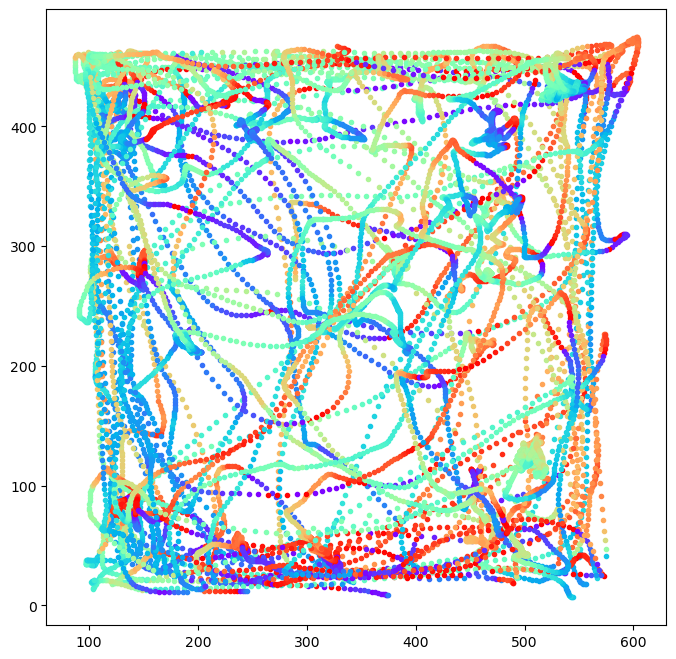

In [32]:
plt.figure(figsize=(8,8))
for f in range(len(body_tracking_results['head_yaw'])):

    if np.isnan(body_tracking_results['head_yaw'][f]):
        continue
    
    plt.plot(
        body_tracking_results['x'][f],
        body_tracking_results['y'][f],
        '.',
        color=cmap[(360-int(np.round(np.rad2deg(body_tracking_results['head_yaw'][f]))))%360]
    )

In [ ]:
int(np.round(np.rad2deg(body_tracking_results['head_yaw'][f])))

In [9]:
print(body_tracking_results['x'][f], body_tracking_results['y'][f])

nan nan


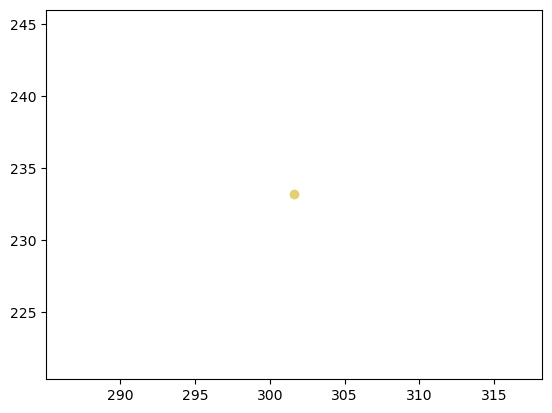

In [33]:
f = 2051

plt.plot(
    body_tracking_results['x'][f],
    body_tracking_results['y'][f],
    'o',
    color=cmap[(360-110)%360]
)

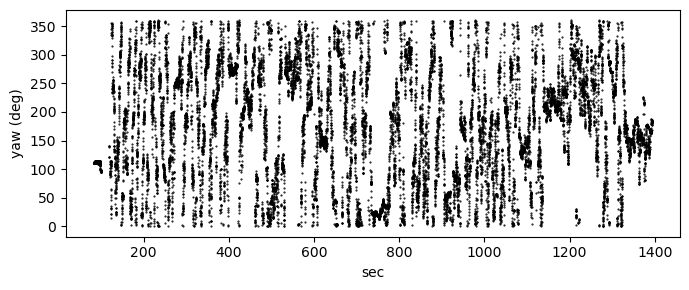

In [13]:
plt.figure(figsize=(7,3))
plt.plot(body_tracking_results['topT']-body_tracking_results['topT'][0], body_tracking_results['head_yaw_deg'], '.', ms=1, color='k', linewidth=1)
plt.xlabel('sec')
plt.ylabel('yaw (deg)')
# plt.ylim([0, 40])
plt.tight_layout()

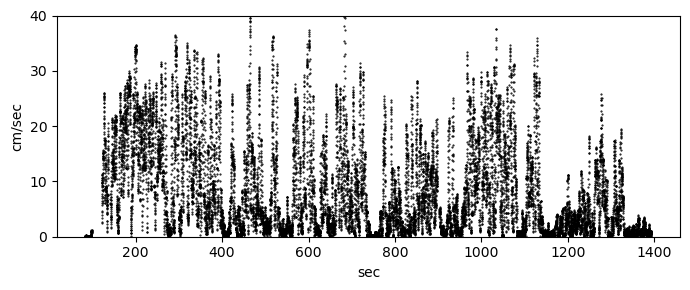

In [14]:
plt.figure(figsize=(7,3))
plt.plot(body_tracking_results['topT'][:-1]-body_tracking_results['topT'][0], body_tracking_results['speed'], '.', ms=1, color='k', linewidth=1)
plt.xlabel('sec')
plt.ylabel('cm/sec')
plt.ylim([0, 40])
plt.tight_layout()

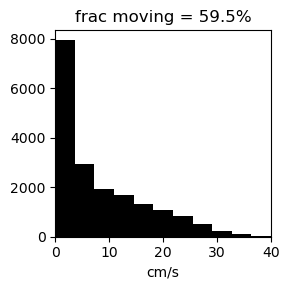

In [15]:
plt.figure(figsize=(3,3))
plt.hist(body_tracking_results['speed'], bins=np.linspace(0, 40, 12), color='k')
plt.xlim([0,40])
plt.xlabel('cm/s')
plt.title('frac moving = {:.3}%'.format(np.sum(body_tracking_results['speed']>2.)/len(body_tracking_results['speed'])*100))
plt.tight_layout()

In [4]:
vidarr = fmr2e.pack_video_frames(r'K:\FreelyMovingEyecams\241204_DMM_DMM031_freelymoving\241204_DMM_DMM031_freelymoving_01_top.avi')

100%|██████████| 21696/21696 [00:13<00:00, 1582.47it/s]


In [5]:
xyl, _ = fmr2e.open_dlc_h5(top.top_dlc_h5)
x_vals, y_vals, likelihood = fmr2e.split_xyl(xyl)

# Threshold by likelihoods
x_vals = fmr2e.apply_liklihood_thresh(x_vals, likelihood)
y_vals = fmr2e.apply_liklihood_thresh(y_vals, likelihood)

In [12]:
vid_save_path = 'demo_topdown_video.avi'

start = 1000
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_vid = cv2.VideoWriter(vid_save_path, fourcc, 60.0, (640, 480))
maxprev = 25

lear_x = x_vals['left_ear_x']
rear_x = x_vals['right_ear_x']
lear_y = y_vals['left_ear_y']
rear_y = y_vals['right_ear_y']
neck_x = x_vals['top_skull_x']
neck_y = y_vals['top_skull_y']
back_x = x_vals['base_tail_x']
back_y = y_vals['base_tail_y']
head_yaw = np.deg2rad(body_tracking_results['head_yaw_deg'])
body_yaw = np.deg2rad(body_tracking_results['body_yaw_deg'])
x_disp = body_tracking_results['x_displacement']
y_disp = body_tracking_results['y_displacement']

for f in tqdm(range(start,start+3600)):

    fig = plt.figure()

    plt.imshow(vidarr[f,:,:].astype(np.uint8), cmap='gray')
    # plt.ylim([135,0])
    # plt.xlim([0,180])
    plt.axis('off')

    plt.plot(lear_x[f], lear_y[f], 'b*')
    plt.plot(rear_x[f], rear_y[f], 'b*')

    plt.plot([neck_x[f], (neck_x[f])+15*np.cos(head_yaw[f])],
                [neck_y[f],(neck_y[f])+15*np.sin(head_yaw[f])],
                '-', linewidth=2, color='cyan') # head yaw
    
    plt.plot([back_x[f], (back_x[f])-15*np.cos(body_yaw[f])],
                [back_y[f], (back_y[f])-15*np.sin(body_yaw[f])],
                '-', linewidth=2, color='pink') # body yaw
    
    for p in range(maxprev):

        prevf = f - p

        plt.plot(neck_x[prevf],
                    neck_y[prevf], 'o', color='tab:purple',
                    alpha=(maxprev-p)/maxprev) # neck position history
        
    # arrow for vector of motion
    if body_tracking_results['forward_run'][f]:
        movvec_color = 'tab:green'
    elif body_tracking_results['backward_run'][f]:
        movvec_color = 'tab:orange'
    elif body_tracking_results['fine_motion'][f]:
        movvec_color = 'tab:olive'
    elif body_tracking_results['stationary'][f]:
        movvec_color = 'tab:red'
    
    plt.arrow(neck_x[f], neck_y[f],
                x_disp[f]*3, y_disp[f]*3,
                color=movvec_color, width=1)
    
    # Save the frame out
    fig.canvas.draw()
    frame_as_array = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    frame_as_array = frame_as_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()

    img = cv2.cvtColor(frame_as_array, cv2.COLOR_RGB2BGR)
    out_vid.write(img.astype('uint8'))

out_vid.release()

  0%|          | 0/3600 [00:00<?, ?it/s]

C:\Users\dmartins\AppData\Local\Temp\ipykernel_9148\3624600016.py:65: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame_as_array = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
C:\Users\dmartins\AppData\Local\Temp\ipykernel_9148\3624600016.py:65: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  frame_as_array = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
100%|██████████| 3600/3600 [02:39<00:00, 22.57it/s]


In [9]:
img.shape

(480, 640, 3)